Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Supervised Learning Visualization - Intermediate Tutorial

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This intermeditate tutorial focuses on demonstrating Tensorflow Similarity's advanced training utilities and visualization capabilities. You will be training a similairty model that will learn how to group images of cats and dogs by training on a subset of the [Oxford-IIIT pet dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) dataset. If you are not yet familiar Tensorflow Similarity, you might want to check out the [Hello World tutorial](https://github.com/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb) to get familiar with the package.

In this notebook you will learn how to use the:

* `TFDatasetMultiShotMemorySampler()` to directly integrate with the Tensorflow dataset catalog. 
* `EfficientNetSim()` model architecture that leverage the [EficientNet](https://keras.io/api/applications/) backbone, data augmentation, and ImageNet pre-trained weights to have an efficient pre-trained model that we will fine-tune for similarity purposes.
* `EvalCallback()` to track the matching classification perfomance during training.
* `SplitValidationLoss()` callback to seperatly visualize how the performance of the seen and unseen classes evolves during training.
* `projector()` to interactivaly explore the test example embedding space. This provides a sense of how well the model clusters similar looking images and which classes are entangled / confused.
* `CircleLoss()`, which is a efficient hyper parameter sensitive loss.

## Imports

In [2]:
import os
import random
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

# INFO and WARNING messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
import tensorflow as tf

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

# Data preparation

In this first step, we are going to load the [Oxford-IIIT pet dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) directly from the 
TensorFlow dataset catalog. This dataset has 37 classes representing different breeds of cats and dogs with roughly 200 images for each class. 

However, the dataset images are not of the same size, so we will need to resize them as part of the data loading. The `EfficientNetSim()` expects images to be 224x224 in the default configuration. However, because we use a random crop and resize layer as part of our augmentation strategy, it is important to have images that are slightly larger than the EfficientNet backbone's input size. Hence, we resize the images to 300 in the function below, which works well but you can experiment with different sizes as long as they are above 224.

In [6]:
IMG_SIZE = 300  # @param {type:"integer"}

# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
    with tf.device("/cpu:0"):
        img = tf.cast(img, dtype="int32")
        img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
        return img, label

## TFDatasetMultiShotMemorySampler

The following cell loads data directly from the TensorFlow catalog using TensorFlow similarity
`TFDatasetMultiShotMemorySampler()`. 

Using a sampler is required to ensure that each batch contains at least N samples of each classes incuded in each batch. Otherwise contrastive loss does not work properly as it can't compute positive distances.

As a Similarity Models allows us to match data from unseen classes, you can experiment with the model's ability to generalize by only trainig on a subset of the classes. Feel free to experiment with the ratio of seen and unseed classes by changing the sampler parameters below. The more classes are seen during training the better it will perform.

In [7]:
training_classes = 16  # @param {type:"slider", min:1, max:37}
examples_per_class_per_batch = 4  # @param {type:"integer"}
train_cls = random.sample(range(37), k=training_classes)
classes_per_batch = max(16, training_classes)
target_img_size = 224  # Size of B0 image input

print(f"Class IDs seen during training {train_cls}")


def img_augmentation(img_batch, y, *args):
    # random resize and crop.
    batch_size = tf.shape(img_batch)[0]
    img_batch = tf.image.random_crop(img_batch, (batch_size, target_img_size, target_img_size, 3))
    # random horizontal flip
    img_batch = tf.image.random_flip_left_right(img_batch)
    return img_batch, y


# use the train split for training
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="train",
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    preprocess_fn=resize,
    class_list=train_cls,
    augmenter=img_augmentation,
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "oxford_iiit_pet",
    splits="test",
    total_examples_per_class=20,
    classes_per_batch=classes_per_batch,
    preprocess_fn=resize,
)

Class IDs seen during training [12, 16, 10, 31, 18, 3, 21, 5, 24, 36, 2, 22, 4, 13, 11, 19]


converting train:   0%|          | 0/3680 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Preprocessing data:   0%|          | 0/3680 [00:00<?, ?it/s]


The initial batch size is 64 (16 classes * 4 examples per class) with 1 augmentations


filtering examples:   0%|          | 0/3680 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/16 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1585 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1585 [00:00<?, ?it/s]

converting test:   0%|          | 0/3669 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3669 [00:00<?, ?it/s]


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/3669 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/37 [00:00<?, ?it/s]

gather examples:   0%|          | 0/740 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/740 [00:00<?, ?it/s]

## class mapping

The following dictionaries map the class ids to the breed's name and the species type (Cat or Dog). These are used later on by the interactive projector.

In [8]:
breeds = {
    0: "Abyssinian",
    1: "American bulldog",
    2: "American pit bull terrier",
    3: "Basset hound",
    4: "Beagle",
    5: "Bengal",
    6: "Birman",
    7: "Bombay",
    8: "Boxer",
    9: "British shorthair",
    10: "Chihuahua",
    11: "Egyptian mau",
    12: "English cocker spaniel",
    13: "English setter",
    14: "German shorthaired",
    15: "Great pyrenees",
    16: "Havanese",
    17: "Japanese chin",
    18: "Keeshond",
    19: "Leonberger",
    20: "Maine coon",
    21: "Miniature pinscher",
    22: "Newfoundland",
    23: "Persian",
    24: "Pomeranian",
    25: "Pug",
    26: "Ragdoll",
    27: "Russian blue",
    28: "Saint bernard",
    29: "Samoyed",
    30: "Scottish terrier",
    31: "Shiba inu",
    32: "Siamese",
    33: "Sphynx",
    34: "Staffordshire bull terrier",
    35: "Wheaten terrier",
    36: "Yorkshire terrier",
}
species = {
    0: "Dog",
    1: "Cat",
    2: "Cat",
    3: "Cat",
    4: "Cat",
    5: "Dog",
    6: "Dog",
    7: "Dog",
    8: "Cat",
    9: "Dog",
    10: "Cat",
    11: "Dog",
    12: "Cat",
    13: "Cat",
    14: "Cat",
    15: "Cat",
    16: "Cat",
    17: "Cat",
    18: "Cat",
    19: "Cat",
    20: "Dog",
    21: "Cat",
    22: "Cat",
    23: "Dog",
    24: "Cat",
    25: "Cat",
    26: "Dog",
    27: "Dog",
    28: "Cat",
    29: "Cat",
    30: "Cat",
    31: "Cat",
    32: "Dog",
    33: "Dog",
    34: "Cat",
    35: "Cat",
    36: "Cat",
}

# Model Setup

# Callbacks

Most metrics used to evaluate similarity models cannot be computed without indexing embeddings and performing query matching classification. TensorFlow Similarity provides callbacks that makes it easy to compute these performance metrics during training. 

These callbacks work by taking two disjoint sets of examples:
1. A set of target examples and labels to be indexed. These will be examples returned by the search.
2. A set of query examples and labels that will be search query. 

Then all metrics metrics are compute be analyzing how many correct matches are returned by the search. While very very fast, this process is still too slow to be done for every training step. Instead the evaluation is only computed `on_epoch_end()`.

Additionally, the `EvalCallback()` and `SplitValidationLoss()` are TensorBoard aware - just add a `tf_logdir` path as illustrated below to have your metric logged. **WARNING** Tensorboard logging requires using a `TensorBoard()` callback that uses the same directory.

In [9]:
num_targets = 200  # @param {type:"integer"}
num_queries = 300  # @param {type:"integer"}
k = 3  # @param {type:"integer"}
log_dir = "logs/%d/" % (time())

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y = test_ds.get_slice(0, num_queries)
targets_x, targets_y = test_ds.get_slice(num_queries, num_targets)
tsc = tfsim.callbacks.EvalCallback(
    queries_x,
    queries_y,
    targets_x,
    targets_y,
    metrics=["f1"],
    k=k,
    # tb_logdir=log_dir  # uncomment if you want to track in tensorboard
)

# Setup an EvalCallback for a known and unknown class split.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    queries_y,
    targets_x,
    targets_y,
    metrics=["binary_accuracy"],
    known_classes=tf.constant(train_cls),
    k=k,
    # tb_logdir=log_dir  # uncomment if you want to track in tensorboard
)

# Adding the Tensorboard callback to track metrics in tensorboard.
# tbc = tf.keras.callbacks.TensorBoard(log_dir=log_dir) # uncomment if you want to track in tensorboard

callbacks = [
    val_loss,
    tsc,
    # tbc # uncomment if you want to track in tensorboard
]

## Model training

We are now going to fine-tune an `EfficientNetSim()` model using `CircleLoss()` function. Because we are fine tuning the model we don't need a lot of epochs. In particular, because the dataset is very small. The small dataset size also means the model will not generalize very well, and the callback metric values will not look impressive. However, this is why visual inspection is important, in practice the matching looks really good and the model is good enough.

To improve performance, you can experiment with:
* change the `embedding_size`.
* set the `EfficientNetSim()` `trainable` parameters to 'partial' or 'full' to unfreeze some or all of the backbone layers.
* changing the loss function to `MultiSimilarityLoss()`, `TripletLoss()`, or any other supported loss.
* tweaking the learning rate.
* tweaking the gamma parameter in the `CircleLoss()`.

Additionally, you can also experiment with replacing the `EfficientNetSim()` with the architecture of your choice. 

In [10]:
embedding_size = 128  # @param {type:"integer"}

# building model
model = tfsim.architectures.EfficientNetSim(
    train_ds.example_shape,
    embedding_size,
    pooling="gem",  # Can change to use `gem` -> GeneralizedMeanPooling2D
    gem_p=3.0,  # Increase the contrast between activations in the feature map.
)

In [11]:
epochs = 5  # @param {type:"integer"}
LR = 0.0001  # @param {type:"number"}
gamma = 256  # @param {type:"integer"} # Loss hyper-parameter. 256 works well here.
steps_per_epoch = 100
val_steps = 50
distance = "cosine"


# init similarity loss
loss = tfsim.losses.CircleLoss(gamma=gamma)

# compiling and training
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=loss,
    distance=distance,
    search='linear',
)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
)

Epoch 1/5
100/100 [==============================] - 19s 136ms/step - loss: 61.9660 - val_loss: 51.0507 - binary_accuracy_known_classes: 0.9067 - binary_accuracy_unknown_classes: 0.8200 - f1: 0.9267
Warmup complete
Epoch 2/5
100/100 [==============================] - 12s 115ms/step - loss: 45.8646 - val_loss: 43.4661 - binary_accuracy_known_classes: 0.9067 - binary_accuracy_unknown_classes: 0.8067 - f1: 0.9228
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 37.5740 - val_loss: 43.7489 - binary_accuracy_known_classes: 0.9400 - binary_accuracy_unknown_classes: 0.8067 - f1: 0.9324
Epoch 4/5
100/100 [==============================] - 12s 118ms/step - loss: 32.1450 - val_loss: 44.4109 - binary_accuracy_known_classes: 0.9067 - binary_accuracy_unknown_classes: 0.8267 - f1: 0.9286
Epoch 5/5
100/100 [==============================] - 11s 114ms/step - loss: 28.0196 - val_loss: 44.9463 - binary_accuracy_known_classes: 0.9200 - binary_accuracy_unknown_classes: 0.8267 - 

# Metric Plotting

The following plots show that the model has a hard time generalizing, as the val loss remains mostly flat while the loss decreases.

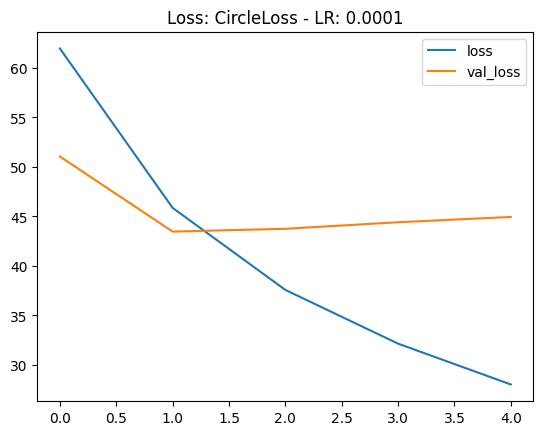

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

Digging deeper, thanks to the `SplitValidationLoss()` callback, we can contrast the binary accuracy for seen and unseen classes. This reveals that the model peak performance happend at epoch 2. As expected, there is a gap between the seen and unseen binary accuracy, however, this gap is fairly small which indicates that the model generalizes fairly well, even though it only trained on 42% of the classes. 

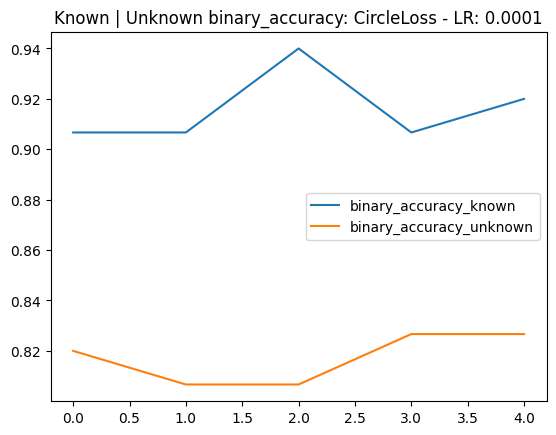

In [13]:
plt.plot(history.history["binary_accuracy_known_classes"])
plt.plot(history.history["binary_accuracy_unknown_classes"])
plt.legend(["binary_accuracy_known", "binary_accuracy_unknown"])
plt.title(f"Known | Unknown binary_accuracy: {loss.name} - LR: {LR}")
plt.show()

# Indexing
We are going to index about 1000 examples from all 37 classes
and use the remainder of the test dataset as unseen queries

In [14]:
# What is indexed
index_size = 360
query_size = 360
index_x, index_y = test_ds.get_slice(0, index_size)
index_data = tf.cast(index_x, dtype="int32")  # casted so it can displayed

# what will be used as never seen before queries to test performance
test_x, test_y = test_ds.get_slice(index_size, query_size)
test_y = [int(c) for c in test_y]
test_data = tf.cast(test_x, dtype="int32")  # casted so it can displayed

In [15]:
model.reset_index()
model.index(index_x, index_y, data=index_data)

[Indexing 360 points]
|-Computing embeddings
12/12 [==============================] - 0s 22ms/step
|-Storing data points in key value store


## Visualize Inspection of the Results

As mentioned earlier, it may be difficult to get a sense of the model quality from the metrics alone. A complementary approach is to manually indpect a set of query results to get a sense of the match quality. Looking at the model result, while imperfect, still returns meaningfully similar results. The model is able to find images of similar looking animals irrespective of their pose or image illumination.

1/1 [==============================] - 0s 28ms/step

Performing NN search



Building NN list:   0%|          | 0/5 [00:00<?, ?it/s]

**Known Class**

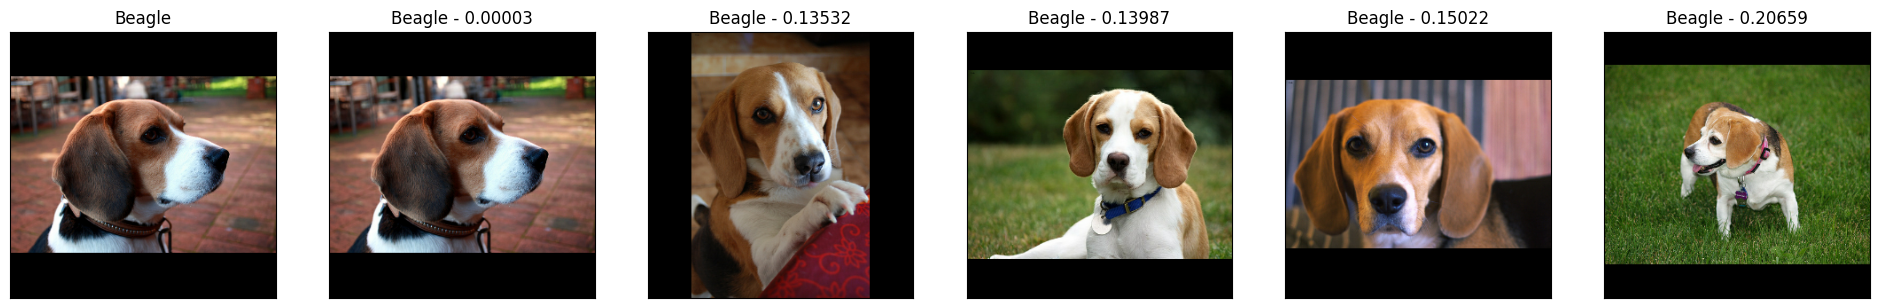

**Known Class**

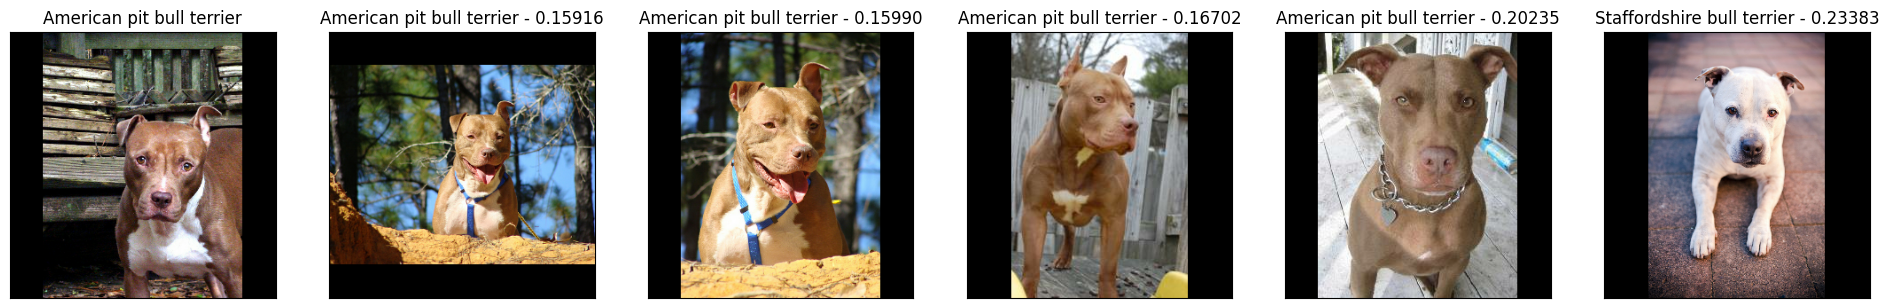

**Unknown Class**

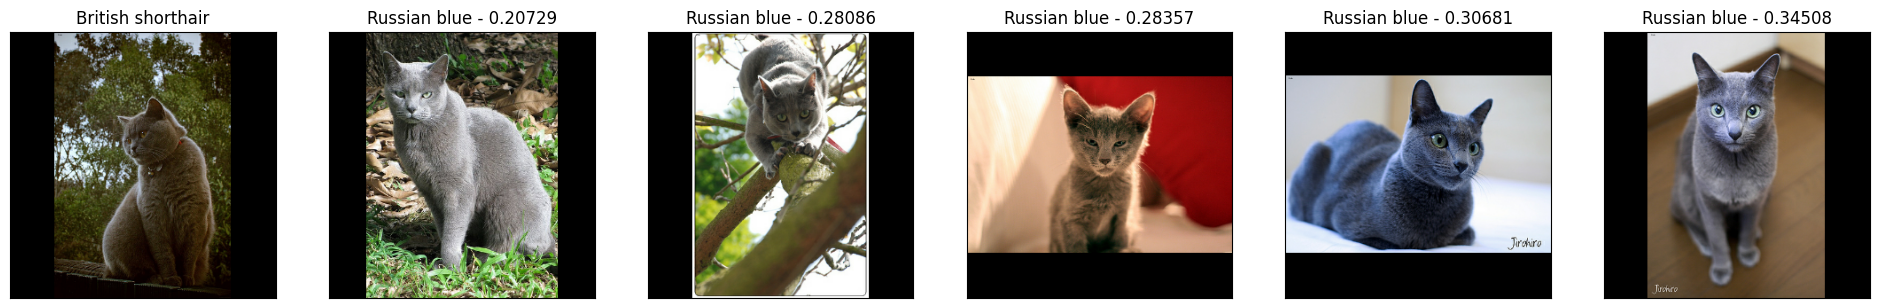

**Known Class**

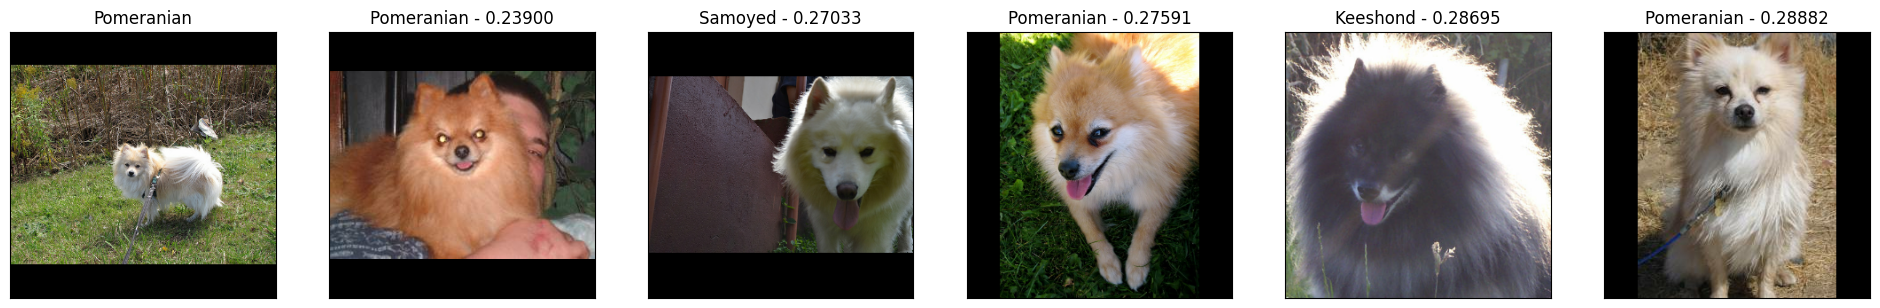

**Unknown Class**

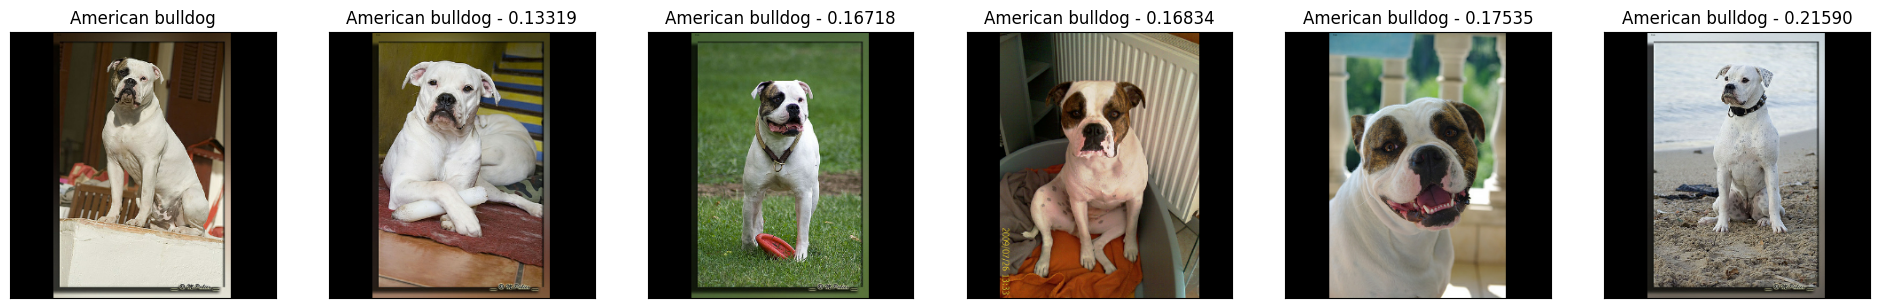

In [16]:
num_examples = 5
num_neigboors = 5
idxs = random.sample(range(len(test_y)), num_examples)
batch = tf.gather(test_x, idxs)
nns = model.lookup(batch, k=num_neigboors)
for bid, nn in zip(idxs, nns):
    # view results close by
    if test_y[bid] in train_cls:
        display(Markdown("**Known Class**"))
    else:
        display(Markdown("**Unknown Class**"))
    tfsim.visualization.viz_neigbors_imgs(test_data[bid], test_y[bid], nn, class_mapping=breeds, cmap="Greys")

## Visualize clusters

One of the best ways to quickly get a sense of the quality of how the model is doing and understand it's short comings is to project the embedding into a 2D space. This allows us to inspect clusters of images and understand which classes are entangled.

In [17]:
num_examples_to_clusters = 720  # @param {type:"integer"}
thumb_size = 96  # @param {type:"integer"}
plot_size = 800
vx, vy = test_ds.get_slice(0, num_examples_to_clusters)
tfsim.visualization.projector(
    model.predict(vx), labels=vy, images=vx, class_mapping=breeds, image_size=thumb_size, plot_size=plot_size
)

23/23 [==============================] - 1s 23ms/step
perfoming projection using UMAP


generating diplayabe images:   0%|          | 0/720 [00:00<?, ?it/s]

Loading BokehJS ...

Loading BokehJS ...

Thank you for following this tutorial till the end. If you are interested in learning about TensorFlow Similarity advanced features, you can checkout our other notebooks.